# Fig3: PBM PDI analyses

- PBMs for CREB1/TBX5
- ChIP-seq analysis for TBX5

In [1]:
from ast import literal_eval
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import patches
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import sys

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smt

from Bio import SeqIO
from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import pearsonr

# import utils
sys.path.append("../")

from data_loading import *
from plotting import y1h_pdi_per_tf_gene_plot, m1h_activation_per_tf_gene_plot, COLOR_PURPLE
from data_loading import (load_annotated_TFiso1_collection, 
                          load_y1h_pdi_data, 
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped)

/PHShome/kz659/.conda/envs/py38/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                     "pdf.fonttype": 42, 
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. CREB1: plot upbm results

In [5]:
kfit_dat = pd.read_table("../../data/processed/pbms/CREB1kfit_dat.csv", sep=",")
da_dat = pd.read_table("../../data/processed/pbms/CREB1da_dat.csv", sep=",")

In [6]:
kfit_ref = kfit_dat[kfit_dat["cname"] == "CREB1-ref"]
kfit_alt = kfit_dat[kfit_dat["cname"] == "CREB1-alt"]

In [7]:
kfit_vs = kfit_ref.merge(kfit_alt, on=["seq"], suffixes=("_ref", "_alt"))

In [8]:
da_alt = da_dat[da_dat["cname"] == "CREB1-alt"]

In [9]:
kfit_vs = kfit_vs.merge(da_alt[["seq", "contrastQ", "contrastQ_cut", 
                                "contrastAverage", "contrastDifference"]], on="seq")

In [10]:
kfit_vs.contains_any_motif_ref.value_counts()

contains_any_motif_ref
*other k-mer    32640
CREB1 k-mer       256
Name: count, dtype: int64

In [11]:
kfit_vs.affinityEstimate_ref.max()

11.5076476898553

In [12]:
def define_other_kmers(row):
    if row.contains_any_motif_ref == "CREB1 k-mer":
        return "* CREB1 k-mer"
    else:
        return "other k-mer"

kfit_vs["contains_any_motif"] = kfit_vs.apply(define_other_kmers, axis=1)
kfit_vs.contains_any_motif.value_counts()

contains_any_motif
other k-mer      32640
* CREB1 k-mer      256
Name: count, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


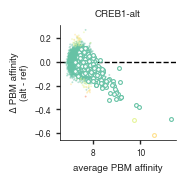

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

markers = [",", "."]
titles = ["CREB1-alt"]

for i, suffix in enumerate(["alt"]):

    for k, motif in enumerate(["other k-mer", "* CREB1 k-mer"]):
        for j, qval in enumerate(["(0.1,1]", "(0.01,0.1]", "(0.001,0.01]", "[0,0.001]"]):
            
            sub = kfit_vs[(kfit_vs["contrastQ_cut"] == qval) & 
                          (kfit_vs["contains_any_motif"] == motif)]
            xs = sub["contrastAverage_alt"]
            ys = sub["contrastDifference_alt"]
            
            color = sns.color_palette("Spectral_r", n_colors=4)[j]
            marker = markers[k]
            
            if marker == "o":
                ax.scatter(xs, ys, 15, marker=marker, edgecolors="black", facecolors=color, alpha=1, linewidth=0.5,
                           zorder=10)
            elif marker == ",":
                ax.scatter(xs, ys, 1, marker=".", edgecolors=color, facecolors='none', alpha=0.5,
                           zorder=10)
            else:
                ax.scatter(xs, ys, 30, marker=marker, edgecolors=color, facecolors='white', alpha=1,
                           zorder=10)
                
    
    ax.axhline(y=0, linestyle="dashed", color="black", linewidth=1, zorder=1)
    ax.set_xlabel("average PBM affinity")
    ax.set_title(titles[i])
    
ax.set_ylabel(u'∆ PBM affinity\n(alt - ref)')

for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
        
fig.savefig("../../figures/fig3/CREB1_isoforms_pbm_MA.pdf", dpi="figure", bbox_inches="tight")

## 2. TBX5: plot PBM results

In [14]:
kfit_dat = pd.read_table("../../data/processed/pbms/TBX5kfit_dat.csv", sep=",")
da_dat = pd.read_table("../../data/processed/pbms/TBX5da_dat.csv", sep=",")

In [15]:
kfit_ref = kfit_dat[kfit_dat["cname"] == "TBX5-ref"]
kfit_3 = kfit_dat[kfit_dat["cname"] == "TBX5-3"]
kfit_2 = kfit_dat[kfit_dat["cname"] == "TBX5-2"]

In [16]:
kfit_vs = kfit_ref.merge(kfit_2, on=["seq"], suffixes=("_ref", ""))
kfit_vs = kfit_vs.merge(kfit_3, on=["seq"], suffixes=("_iso2", "_iso3"))
kfit_vs.head()

,seq,cname_ref,affinityEstimate_ref,affinityVariance_ref,contrastDifference_ref,contrastAverage_ref,contrastVariance_ref,contains_any_motif_ref,cname_iso2,affinityEstimate_iso2,...,contrastAverage_iso2,contrastVariance_iso2,contains_any_motif_iso2,cname_iso3,affinityEstimate_iso3,affinityVariance_iso3,contrastDifference_iso3,contrastAverage_iso3,contrastVariance_iso3,contains_any_motif_iso3
0,AAAAAAAA,TBX5-ref,10.028611,0.004803,NaN,NaN,NaN,other k-mer,TBX5-2,9.903240,...,9.965926,0.003227,other k-mer,TBX5-3,9.931881,0.003412,-0.096730,9.980246,0.003536,other k-mer
1,AAAAAAAC,TBX5-ref,9.956585,0.001912,NaN,NaN,NaN,other k-mer,TBX5-2,9.934673,...,9.945629,0.005728,other k-mer,TBX5-3,9.957827,0.003953,0.001242,9.957206,0.003823,other k-mer
2,AAAAAAAG,TBX5-ref,10.115281,0.008088,NaN,NaN,NaN,other k-mer,TBX5-2,10.040526,...,10.077904,0.004583,other k-mer,TBX5-3,9.936246,0.004633,-0.179034,10.025764,0.005549,other k-mer
3,AAAAAAAT,TBX5-ref,10.020661,0.004480,NaN,NaN,NaN,other k-mer,TBX5-2,9.994817,...,10.007739,0.003959,other k-mer,TBX5-3,9.973363,0.002724,-0.047297,9.997012,0.004635,other k-mer
4,AAAAAACA,TBX5-ref,10.005205,0.005584,NaN,NaN,NaN,other k-mer,TBX5-2,9.981221,...,9.993213,0.004405,other k-mer,TBX5-3,9.912703,0.003827,-0.092501,9.958954,0.004838,other k-mer


In [17]:
da_3 = da_dat[da_dat["cname"] == "TBX5-3"]
da_2 = da_dat[da_dat["cname"] == "TBX5-2"]

In [18]:
kfit_vs = kfit_vs.merge(da_2[["seq", "contrastQ", "contrastQ_cut"]], on="seq")
kfit_vs = kfit_vs.merge(da_3[["seq", "contrastQ", "contrastQ_cut"]], on="seq", suffixes=("_iso2", "_iso3"))

In [19]:
kfit_vs.contains_any_motif_ref.value_counts()

contains_any_motif_ref
other k-mer     32848
* TBX5 k-mer       48
Name: count, dtype: int64

In [20]:
def add_motif_category(row, motif_name, motif, motif_rc):
    if motif in row.seq or motif_rc in row.seq:
        return motif_name
    else:
        return row.contains_any_motif_ref

kfit_vs["contains_any_motif_ref"] = kfit_vs.apply(add_motif_category, motif_name="* ACGTGT k-mer",
                                                  motif="ACGTGT", motif_rc="ACACGT", axis=1)
kfit_vs.contains_any_motif_ref.value_counts()

contains_any_motif_ref
other k-mer       32800
* TBX5 k-mer         48
* ACGTGT k-mer       48
Name: count, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


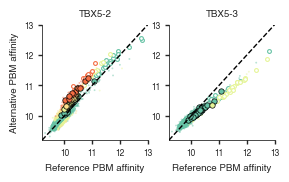

In [21]:
fig, axarr = plt.subplots(1, 2, figsize=(3, 1.5))

markers = [",", ".", "o"]
titles = ["TBX5-2", "TBX5-3"]

for i, suffix in enumerate(["iso2", "iso3"]):
    
    ax = axarr[i]

    for k, motif in enumerate(["other k-mer", "* TBX5 k-mer", "* ACGTGT k-mer"]):
        for j, qval in enumerate(["(0.1,1]", "(0.01,0.1]", "(0.001,0.01]", "[0,0.001]"]):
            
            sub = kfit_vs[(kfit_vs["contrastQ_cut_%s" % suffix] == qval) & 
                          (kfit_vs["contains_any_motif_ref"] == motif)]
            xs = sub["affinityEstimate_ref"]
            ys = sub["affinityEstimate_%s" % suffix]
            
            color = sns.color_palette("Spectral_r", n_colors=4)[j]
            marker = markers[k]
            
            if marker == "o":
                ax.scatter(xs, ys, 15, marker=marker, edgecolors="black", facecolors=color, alpha=1, linewidth=0.5)
            elif marker == ",":
                ax.scatter(xs, ys, 1, marker=".", edgecolors=color, facecolors='none', alpha=0.5)
            else:
                ax.scatter(xs, ys, 30, marker=marker, edgecolors=color, facecolors='white', alpha=1)
                
    
    ax.set_xlim((9.2, 13))
    ax.set_ylim((9.2, 13))
    ax.plot([9.2, 13], [9.2, 13], color="black", linestyle="dashed", linewidth=1, zorder=1)
    ax.set_xticks([10, 11, 12, 13])
    ax.set_yticks([10, 11, 12, 13])
    ax.set_xlabel("Reference PBM affinity")
    ax.set_title(titles[i])
    
axarr[0].set_ylabel("Alternative PBM affinity")

for loc in ['top', 'right']:
    axarr[0].spines[loc].set_visible(False)
    axarr[1].spines[loc].set_visible(False)
    
fig.savefig("../../figures/fig3/TBX5_isoforms_pbm_scatter.pdf", dpi="figure", bbox_inches="tight")

## 3. TBX5: plot expression profiles

In [22]:
def developmental_tissue_expression_plot(gene_name, figsize, ylim, means, cols, fig_suffix):
    locs = [x for x in list(means.index) if x.split("|")[0] == gene_name]
    
    # include isos that aren't cloned
    locs = list(set(locs + [x for x in list(means.index) if x.split(" ")[1][:-4] == gene_name]))
    
    n_isos = len(means.loc[locs])
    palette = sns.color_palette("Set2")
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[locs, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[locs, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(TPM + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('Percent of\ngene expression')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig3/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

In [23]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


In [24]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


/tmp/ipykernel_187955/2457522684.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


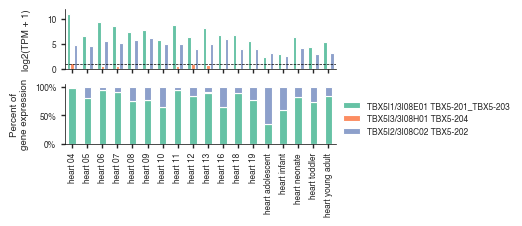

In [25]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
ovary_cols = [x for x in means_dev.columns if "ovary" in x]
developmental_tissue_expression_plot("TBX5", (3.5, 1.75), (0, 12), means_dev, heart_cols, 
                                     "means_dev_heart")

/tmp/ipykernel_187955/2457522684.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


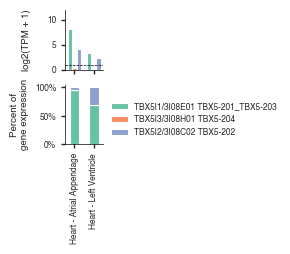

In [26]:
heart_cols = [x for x in means_gtex.columns if "Heart" in x]
developmental_tissue_expression_plot("TBX5", (0.5, 1.75), (0, 12), means_gtex, heart_cols, 
                                     "means_gtex_heart")

## 4. TBX5: ChIP analyses

ChIP data is already filtered:
don't use any mut/WT data (some of these are from mutant GATA4, for example, which can disrupt TBX5 recruitment: https://pubmed.ncbi.nlm.nih.gov/27984724/)

antibody antigens:
- Sigma SAB1411331 immunogen is FL protein (https://www.sigmaaldrich.com/US/en/product/sigma/sab1411331) -- will recognize all (?)
- Santa Cruz sc17866/C-20 immunogen is C-terminus (https://datasheets.scbt.com/sc-17866.pdf) -- will recognize REF and B05 (but not A05)

and peaks are already centered and are non-overlapping

### variables

In [27]:
chip_seqs_f = "../../data/external/chip/03__fasta/TBX5_ChIP_filtered_studies.non_overlapping.centered_final.good_chr.fa"
genre_seqs_f = "../../data/external/chip/05__genre_fasta/genre.fasta"
upbm_f = "../../data/processed/pbms/TBX5kfit_dat.csv"

In [28]:
motif = "AGGTGT"
motif_rc = "ACACCT"

sp_motif = "ACGTGT"
sp_motif_rc = "ACACGT"

### 1. import data

In [29]:
upbm = pd.read_table(upbm_f, sep=",")
upbm.head()

,seq,cname,affinityEstimate,affinityVariance,contrastDifference,contrastAverage,contrastVariance,contains_any_motif
0,AAAAAAAA,TBX5-ref,10.028611,0.004803,NaN,NaN,NaN,other k-mer
1,AAAAAAAA,TBX5-3,9.931881,0.003412,-0.096730,9.980246,0.003536,other k-mer
2,AAAAAAAA,TBX5-2,9.903240,0.006690,-0.125371,9.965926,0.003227,other k-mer
3,AAAAAAAC,TBX5-ref,9.956585,0.001912,NaN,NaN,NaN,other k-mer
4,AAAAAAAC,TBX5-3,9.957827,0.003953,0.001242,9.957206,0.003823,other k-mer


In [30]:
names = []
seqs = []

for record in SeqIO.parse(chip_seqs_f, "fasta"):
    names.append(record.id)
    seqs.append(str(record.seq))

In [31]:
chip = pd.DataFrame([names, seqs]).T
chip.columns = ["id", "seq"]

In [32]:
names = []
seqs = []

for record in SeqIO.parse(genre_seqs_f, "fasta"):
    names.append(record.id)
    seqs.append(str(record.seq))

In [33]:
genre = pd.DataFrame([names, seqs]).T
genre.columns = ["id", "seq"]
genre.head()

,id,seq
0,chr1:100344878-100345028,AATTTTCTTCTAGAGTTTCTACACAGGACTAGGCATCAGAAAACAT...
1,chr19:38843178-38843328,GTCTTGTTGGGGGGCTGCCGCTGTTTCTCATAGGCAATCCTCCACC...
2,chr15:101027144-101027294,TCACGAGTTCTCCAGACTTGCCAGCGTTCAGGACAAACCTCTCAGG...
3,chr20:40494364-40494514,AGGAGAGAATCATAGGTTTTGCAAGAGCCCTTTGTTTGCCTGGGGC...
4,chr7:28958896-28959046,AGCAGTGGGAGCGCGCCTGGCCTTCCTCGTTGTTAAGTCACTTGCT...


In [34]:
print(len(chip))
print(len(genre))

2074
2074


In [35]:
chip["peak_len"] = chip.seq.str.len()
print(chip.peak_len.unique())

[150]


In [36]:
genre["peak_len"] = genre.seq.str.len()
print(genre.peak_len.unique())

[150]


### 2. plot k-mer distribution

In [37]:
def get_kmer_ocurrences(row, kmer, kmer_rc):
    kmer_oc = [m.start() for m in re.finditer('(?=%s)' % kmer, row.seq)]
    kmer_rc_oc = [m.start() for m in re.finditer('(?=%s)' % kmer_rc, row.seq)]
    
    kmer_arr = np.zeros(150)
    for oc in kmer_oc:
        kmer_arr[oc:oc+len(kmer)] += 1
    for oc in kmer_rc_oc:
        kmer_arr[oc:oc+len(kmer_rc)] += 1
    
    return kmer_arr

In [38]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [39]:
chip["motif_arr"] = chip.apply(get_kmer_ocurrences, kmer=motif, kmer_rc=motif_rc, axis=1)
chip["sp_motif_arr"] = chip.apply(get_kmer_ocurrences, kmer=sp_motif, kmer_rc=sp_motif_rc, axis=1)
chip["hd_arr"] = chip.apply(get_kmer_ocurrences, kmer="TAATTA", kmer_rc="TAATTA", axis=1)

In [40]:
m = np.sum(np.array(chip["motif_arr"].tolist()), axis=0)
sm = np.sum(np.array(chip["sp_motif_arr"].tolist()), axis=0)
h = np.sum(np.array(chip["hd_arr"].tolist()), axis=0)

In [41]:
m_av = moving_average(m, 8)
sm_av = moving_average(sm, 8)
h_av = moving_average(h, 8)

In [42]:
genre["motif_arr"] = genre.apply(get_kmer_ocurrences, kmer=motif, kmer_rc=motif_rc, axis=1)
genre["sp_motif_arr"] = genre.apply(get_kmer_ocurrences, kmer=sp_motif, kmer_rc=sp_motif_rc, axis=1)
genre["hd_arr"] = genre.apply(get_kmer_ocurrences, kmer="TAATTA", kmer_rc="TAATTA", axis=1)

In [43]:
m_g = np.sum(np.array(genre["motif_arr"].tolist()), axis=0)
sm_g = np.sum(np.array(genre["sp_motif_arr"].tolist()), axis=0)
h_g = np.sum(np.array(genre["hd_arr"].tolist()), axis=0)

In [44]:
m_g_av = moving_average(m_g, 8)
sm_g_av = moving_average(sm_g, 8)
h_g_av = moving_average(h_g, 8)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


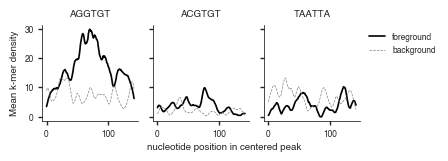

In [45]:
fig, axarr = plt.subplots(1, 3, figsize=(4.5, 1.5), sharey=True, sharex=True)

i = 0
for fg_arr, bg_arr, kmer in zip([m_av, sm_av, h_av], [m_g_av, sm_g_av, h_g_av], 
                                 [motif, sp_motif, "TAATTA"]):
    
    ax = axarr[i]
    
    ax.plot(fg_arr, label="%s foreground" % kmer, color="black")
    ax.plot(bg_arr, linestyle="dashed", label="%s background" % kmer, color="grey", linewidth=0.5)

    ax.set_title(kmer)
    
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    
    if i == 2:
        ax.legend(loc=2, bbox_to_anchor=(1.01, 1), labels=["foreground", "background"], frameon=False)
        
    i += 1

axarr[0].set_ylabel("Mean k-mer density")
fig.text(0.5, 0, "nucleotide position in centered peak", ha="center")
    
plt.tight_layout()
fig.savefig("../../figures/fig3/TBX5_chip_density.pdf", dpi="figure", bbox_inches="tight")

### 5. fisher test for foreground vs. background rates

In [46]:
def has_motif(row, col):
    arr = row[col]
    arr_sum = np.sum(arr)
    if arr_sum > 0:
        return 1
    else:
        return 0
    
chip["has_motif"] = chip.apply(has_motif, col="motif_arr", axis=1)
chip["has_sp_motif"] = chip.apply(has_motif, col="sp_motif_arr", axis=1)
chip["has_hd"] = chip.apply(has_motif, col="hd_arr", axis=1)

In [47]:
genre["has_motif"] = genre.apply(has_motif, col="motif_arr", axis=1)
genre["has_sp_motif"] = genre.apply(has_motif, col="sp_motif_arr", axis=1)
genre["has_hd"] = genre.apply(has_motif, col="hd_arr", axis=1)

In [48]:
motif_tab = np.zeros((2, 2))
sp_motif_tab = np.zeros((2, 2))
hd_tab = np.zeros((2, 2))

In [49]:
n_m_fore = len(chip[chip["has_motif"] == 1])
n_nom_fore = len(chip[chip["has_motif"] == 0])

n_m_bg = len(genre[genre["has_motif"] == 1])
n_nom_bg = len(genre[genre["has_motif"] == 0])

motif_tab[0, 0] = n_m_fore
motif_tab[0, 1] = n_nom_fore
motif_tab[1, 0] = n_m_bg
motif_tab[1, 1] = n_nom_bg

fisher_exact(motif_tab)

SignificanceResult(statistic=2.242428146296845, pvalue=1.3253547476291926e-17)

In [50]:
n_m_fore = len(chip[chip["has_sp_motif"] == 1])
n_nom_fore = len(chip[chip["has_sp_motif"] == 0])

n_m_bg = len(genre[genre["has_sp_motif"] == 1])
n_nom_bg = len(genre[genre["has_sp_motif"] == 0])

sp_motif_tab[0, 0] = n_m_fore
sp_motif_tab[0, 1] = n_nom_fore
sp_motif_tab[1, 0] = n_m_bg
sp_motif_tab[1, 1] = n_nom_bg

fisher_exact(sp_motif_tab)

SignificanceResult(statistic=1.94431213224993, pvalue=0.0005096009312903356)

In [51]:
n_m_fore = len(chip[chip["has_hd"] == 1])
n_nom_fore = len(chip[chip["has_hd"] == 0])

n_m_bg = len(genre[genre["has_hd"] == 1])
n_nom_bg = len(genre[genre["has_hd"] == 0])

hd_tab[0, 0] = n_m_fore
hd_tab[0, 1] = n_nom_fore
hd_tab[1, 0] = n_m_bg
hd_tab[1, 1] = n_nom_bg

fisher_exact(hd_tab)

SignificanceResult(statistic=0.6062723061735895, pvalue=0.008452010140594738)

In [52]:
motif_df = pd.DataFrame(motif_tab)
motif_df.index = ["foreground", "background"]
motif_df.columns = ["%s" % motif, "no %s" % motif]
motif_df.reset_index(inplace=True)
motif_m = pd.melt(motif_df, id_vars="index")

sp_motif_df = pd.DataFrame(sp_motif_tab)
sp_motif_df.index = ["foreground", "background"]
sp_motif_df.columns = ["%s" % sp_motif, "no %s" % sp_motif]
sp_motif_df.reset_index(inplace=True)
sp_motif_m = pd.melt(sp_motif_df, id_vars="index")
motif_m = pd.concat([motif_m, sp_motif_m]) 

hd_motif_df = pd.DataFrame(hd_tab)
hd_motif_df.index = ["foreground", "background"]
hd_motif_df.columns = ["TAATTA", "no TAATTA"]
hd_motif_df.reset_index(inplace=True)
hd_motif_m = pd.melt(hd_motif_df, id_vars="index")
motif_m = pd.concat([motif_m, hd_motif_m])

motif_m["frac"] = motif_m["value"]/len(chip)

/tmp/ipykernel_187955/3620073561.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


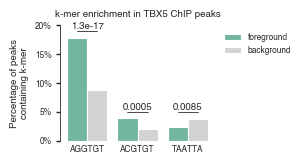

In [53]:
fig = plt.figure(figsize=(2, 1.5))

pal = {"foreground": sns.color_palette("Set2")[0], "background": "lightgrey"}

ax = sns.barplot(data=motif_m[~motif_m["variable"].str.startswith("no")],
                 x="variable", y="frac", hue="index", palette=pal)
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of peaks\ncontaining k-mer")
ax.set_ylim((0, 0.2))
ax.set_title("k-mer enrichment in TBX5 ChIP peaks")
ax.set_xlabel("")

# annotate p-values
i = 0
for tab, y in zip([motif_tab, sp_motif_tab, hd_tab], [0.19, 0.05, 0.05]):
    pval = fisher_exact(tab)
    
    ax.plot([i-0.2, i+0.2], [y, y], color="black", linewidth=0.5)
    
    p = fisher_exact(tab)[1]
    if p < 1e-6:
        s = "{:.1e}".format(p)
    else:
        s = np.round(p, 4)
    
    ax.text(i, y, s, ha="center", va="bottom", fontsize=7)
    i += 1

for loc in ['top', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])  

fig.savefig("../../figures/fig3/TBX5_chip_enrichment.pdf", dpi="figure", bbox_inches="tight")